In [636]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None # to turn off the chained assignments

_________________________________
Import inventories dataframe

In [637]:
df_inventories = pd.concat(
    map(pd.read_csv, ['data/lego_sets_2012.csv', 'data/lego_sets_2013.csv', 'data/lego_sets_2014.csv', 'data/lego_sets_2015.csv', 'data/lego_sets_2016.csv', 'data/lego_sets_2017.csv', 'data/lego_sets_2018.csv', 'data/lego_sets_2019.csv', 'data/lego_sets_2020.csv', 'data/lego_sets_2021.csv', 'data/lego_sets_2022.csv']), ignore_index= True)

In [638]:
df_inventories.describe()

,Year,Minifigs,Pieces,RRP (GBP),RRP (USD),RRP (CAD),RRP (EUR),EAN,UPC,Width,...,Flag 1 not used,Flag 2 not used,Flag 3 not used,Flag 4 not used,Flag 5 not used,Flag 6 not used,Flag 7 not used,Flag 8 not used,Value new (USD),Value used (USD)
count,8960.000000,4380.000000,6623.000000,5518.000000,5978.000000,4959.000000,4311.000000,4.591000e+03,4.048000e+03,4999.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6223.000000,4863.000000
mean,2017.201897,2.711187,293.742111,31.808079,35.732753,50.414866,40.653957,5.570997e+12,6.733013e+11,26.001103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.807138,35.659745
std,3.110600,2.777822,589.358683,47.871629,55.157096,70.917301,59.315827,8.015292e+11,1.716260e+10,13.951904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.057426,65.366815
min,2012.000000,1.000000,0.000000,0.000000,0.000000,2.490000,0.010000,6.734191e+11,1.826580e+11,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.050000,0.250000
25%,2015.000000,1.000000,29.000000,7.990000,8.230000,13.990000,9.990000,5.702015e+12,6.734192e+11,14.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.495000,5.360000
50%,2017.000000,2.000000,96.000000,17.990000,19.990000,24.990000,19.990000,5.702016e+12,6.734193e+11,25.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.640000,14.150000
75%,2020.000000,3.000000,316.500000,34.990000,39.990000,54.990000,49.990000,5.702017e+12,6.734193e+11,35.407600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.110000,37.230000
max,2022.000000,32.000000,11695.000000,734.990000,849.990000,1049.990000,849.990000,9.788325e+12,8.839294e+11,116.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9000.000000,1329.050000


Import scraped Ebay data dataframe

In [639]:
df_ebay = pd.read_csv('lego_ebay_sold_price.csv', parse_dates=True)

In [640]:
df_ebay.describe()

,title,currency,sold_price,sold_date
count,22347,22226,22226,22447
unique,13139,2,3894,12
top,title,£,sold_price,11 Sep 2022
freq,367,21859,367,3752


___________________________________________________________________
# EDA

CLEAN LEGO INVENTORIES DATA

Remove unused columns and copy to new DataFrame

In [641]:
df_inventories_cleaned = df_inventories[['Number', 'Theme' , 'Minifigs', 'Pieces', 'RRP (GBP)', 'Launch date', 'Exit date']]

In [642]:
df_inventories_cleaned.isnull().sum()

Number            0
Theme             0
Minifigs       4580
Pieces         2337
RRP (GBP)      3442
Launch date    4326
Exit date      4326
dtype: int64

Any missing RRP will be not useful in this analysis. 

So we drop them

In [643]:
df_inventories_cleaned = df_inventories_cleaned[~df_inventories_cleaned['RRP (GBP)'].isna()]

We clean the set number to contain only the main code

In [644]:
df_inventories_cleaned['Number'] = df_inventories_cleaned['Number'].str.replace(r'-\d+', '', regex=True).str.replace(r'\D','', regex=True)
df_inventories_cleaned = df_inventories_cleaned[~(df_inventories_cleaned['Number'] == '')]
df_inventories_cleaned['Number'] = df_inventories_cleaned['Number'].astype('int64')

In [645]:
df_inventories_cleaned

,Number,Theme,Minifigs,Pieces,RRP (GBP),Launch date,Exit date
0,3061,Friends,2.0,222.0,29.99,01/01/2012,31/12/2013
1,3063,Friends,1.0,195.0,19.99,01/06/2012,31/12/2013
2,3065,Friends,1.0,191.0,19.99,01/01/2012,31/12/2013
3,3183,Friends,1.0,130.0,14.99,01/01/2012,31/07/2013
4,3184,Friends,2.0,309.0,29.99,01/06/2012,31/12/2013
...,...,...,...,...,...,...,...
8904,5007454,Gear,NaN,NaN,24.99,NaN,NaN
8905,5007455,Gear,NaN,NaN,24.99,NaN,NaN
8909,5007486,Gear,NaN,NaN,39.99,NaN,NaN
8911,5007493,Gear,NaN,NaN,24.99,NaN,NaN


********************************************
CLEAN SCRAPED EBAY DATA

Extract all numbers found in title into columns

In [646]:

# Extract all numbers in title to a list in a new DataFrame: normally LEGO's numbers code, number of pieces, set quantity, number of minifigures, etc.
df_numbers = df_ebay['title'].str.findall('([0-9]+)').to_list()

# Express all values in list to multi columns, each with one value.
# As with LEGO sets, the number of pieces is usually smaller than the actual number code. Other number are significantly smaller than the pieces and number code.
# Fill all nan value with 0, convert to int data type to find the max value

# df_numbers = df_ebay.numbers.apply(pd.Series).fillna(0).astype(int).max(axis=1)
df_numbers = pd.DataFrame([pd.Series(x, dtype = 'float') for x in df_numbers]).fillna(0).astype(int).max(axis=1) # Use this method to avoid the warning: 'The default dtype for empty Series will be 'object' instead of 'float64' in a future version warning'

In [647]:
df_ebay_cleaned = df_ebay[['title', 'currency','sold_price', 'sold_date']]

In [648]:
# Update the column 'numbers' with the correct value
df_ebay_cleaned.loc[:,'Number'] = df_numbers
# Check null values in the set
df_ebay_cleaned.isnull().sum()

title         100
currency      221
sold_price    221
sold_date       0
Number          0
dtype: int64

In [649]:
# Remove duplicates
df_ebay_cleaned = df_ebay_cleaned.drop_duplicates()

Remove Outlier

Are those any invalid values: set number smaller than 999 and larger than 99999

In [650]:
filter = ((df_ebay_cleaned['Number'] < 999) | (df_ebay_cleaned['Number'] > 99999))
filter.sum()

2414

There are invalid values. We're going to drop them.

In [651]:
# Take only row with a valid numbers: number set is from 999 to 99999. 
df_ebay_cleaned = df_ebay_cleaned[~filter]
# Also we droped any row with sold_price is null
df_ebay_cleaned = df_ebay_cleaned[df_ebay_cleaned['sold_price'].notnull()]
df_ebay_cleaned['sold_price'] =df_ebay_cleaned['sold_price'].astype(float)

In [652]:
df_ebay_cleaned.shape

(12968, 5)

# Merge two dataset

In [653]:
df = pd.merge(df_ebay_cleaned, df_inventories_cleaned, how='inner', on =['Number'])

In [654]:
df

,title,currency,sold_price,sold_date,Number,Theme,Minifigs,Pieces,RRP (GBP),Launch date,Exit date
0,Lego STAR WARS MILLENNIUM FALCON BRAND NEW 135...,£,108.79,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
1,LEGO Millennium Falcon Star Wars TM (75257) *F...,£,117.50,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
2,LEGO Millennium Falcon Star Wars TM (75257) 13...,£,119.23,7 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
3,"LEGO Star Wars: Millennium Falcon (75257), new...",£,109.00,10 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
4,LEGO Millennium Falcon Star Wars TM (75257) 13...,£,118.27,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
...,...,...,...,...,...,...,...,...,...,...,...
12543,Lego The LEGO Movie 2 Rex's Rex-treme Offroade...,£,17.00,12 Sep 2022,70826,The LEGO Movie 2,2.0,236.0,24.99,01/01/2019,31/12/2019
12544,SET BOITE LEGO STAR WARS VAISSEAU 75145 DENGAR...,£,46.73,12 Sep 2022,75145,Star Wars,2.0,363.0,39.99,01/06/2016,31/12/2017
12545,LEGO LEGO CLASSIC: Bricks and Functions (11019...,£,16.00,12 Sep 2022,11019,Classic,NaN,500.0,29.99,01/03/2022,31/12/2023
12546,LEGO CITY: People Pack - Fun in the Park (6013...,£,34.17,12 Sep 2022,60134,City,15.0,157.0,34.99,01/06/2016,31/12/2017


***************************************************************************************************************************************************************


# Exploratory Data Analysis

## Total sold themes wise

In [655]:
len(df['Theme'].unique())

77

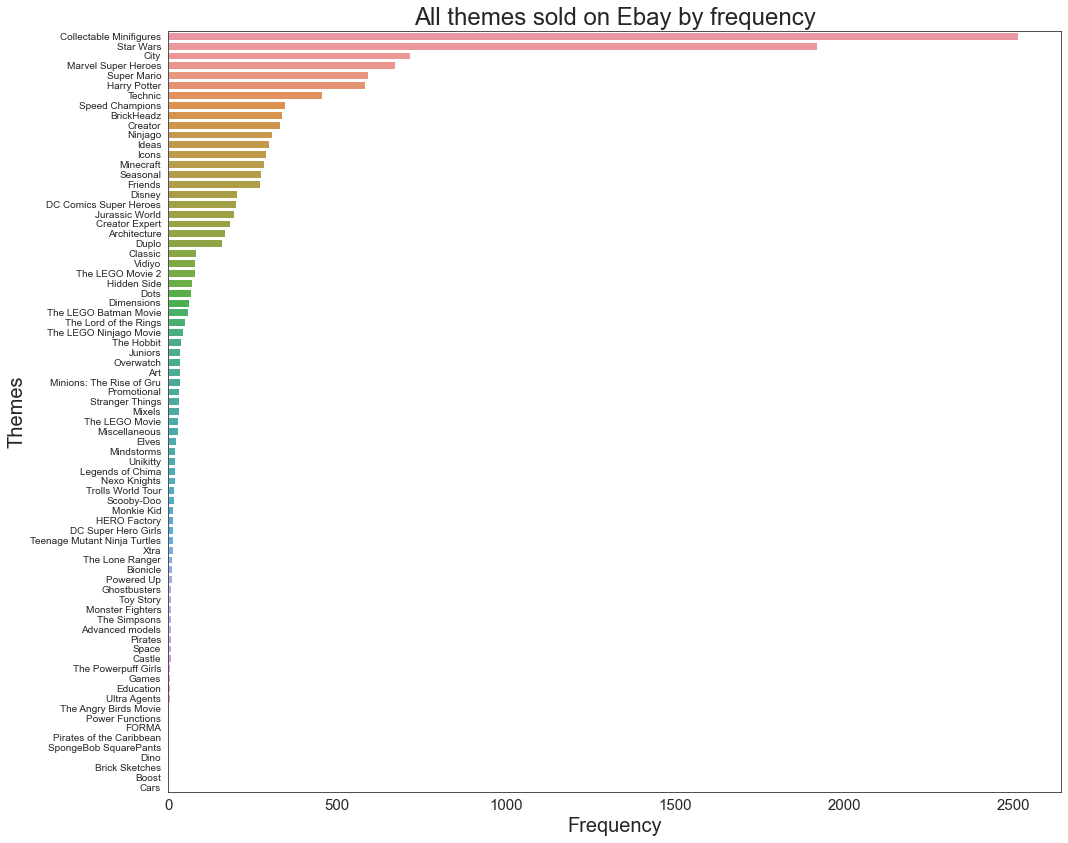

In [656]:
fig, ax = plt.subplots(figsize = (16,14))
themes_count = df['Theme'].value_counts()
ax = sns.barplot(x = themes_count, y = themes_count.index, data=df)
plt.xticks(size=15)
plt.xlabel('Frequency', size = 20)
plt.ylabel('Themes', size = 20)
plt.title('All themes sold on Ebay by frequency', size = 24)
plt.show()


There are a number of themes have verry little sold. So these are considered as outlier and we will remove them in the analysis.

In [657]:
ix = df['Theme'].value_counts()[df['Theme'].value_counts()<100].index
index = df[df['Theme'].isin(ix)].index
df.drop(index, axis=0, inplace=True)

In [658]:
df

,title,currency,sold_price,sold_date,Number,Theme,Minifigs,Pieces,RRP (GBP),Launch date,Exit date
0,Lego STAR WARS MILLENNIUM FALCON BRAND NEW 135...,£,108.79,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
1,LEGO Millennium Falcon Star Wars TM (75257) *F...,£,117.50,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
2,LEGO Millennium Falcon Star Wars TM (75257) 13...,£,119.23,7 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
3,"LEGO Star Wars: Millennium Falcon (75257), new...",£,109.00,10 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
4,LEGO Millennium Falcon Star Wars TM (75257) 13...,£,118.27,9 Sep 2022,75257,Star Wars,7.0,1351.0,149.99,04/10/2019,31/12/2023
...,...,...,...,...,...,...,...,...,...,...,...
12540,LEGO Technic Forest Machine - Set 42080 Build ...,£,145.22,12 Sep 2022,42080,Technic,NaN,1003.0,119.99,01/08/2018,31/12/2019
12542,2017 Lego Technic Ultralight Helicopter (42057),£,30.00,12 Sep 2022,42057,Technic,NaN,199.0,14.99,NaN,NaN
12544,SET BOITE LEGO STAR WARS VAISSEAU 75145 DENGAR...,£,46.73,12 Sep 2022,75145,Star Wars,2.0,363.0,39.99,01/06/2016,31/12/2017
12546,LEGO CITY: People Pack - Fun in the Park (6013...,£,34.17,12 Sep 2022,60134,City,15.0,157.0,34.99,01/06/2016,31/12/2017


## Price range of themes

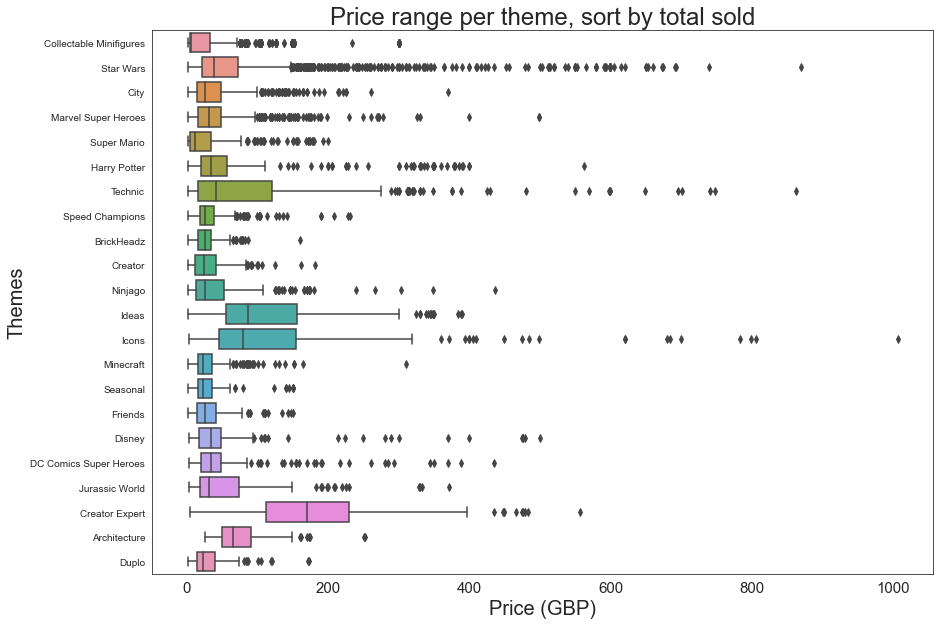

In [659]:
fig, ax = plt.subplots(figsize = (14,10))
order = df['Theme'].value_counts().index
ax = sns.boxplot(data=df, x='sold_price', y='Theme', order=order)
plt.xticks(size=15)
plt.xlabel('Price (GBP)', size = 20)
plt.ylabel('Themes', size = 20)
plt.title('Price range per theme, sort by total sold', size = 24)
plt.show()

We can notice many outliers in each set. The reason might be some sellers sold multiple sets per ad. But to keep the simplicity of this analysis, we don't address this problem. Instead, we treat these as outliers needed to be removed.

### Remove outliers using IQR

In [660]:
# IQR : Inter Quarltile Range
Q1 = df['sold_price'].quantile(0.25)
Q3 = df['sold_price'].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df['sold_price'] < (Q1 - 1.5 * IQR)) |(df['sold_price'] > (Q3 + 1.5 * IQR)))]

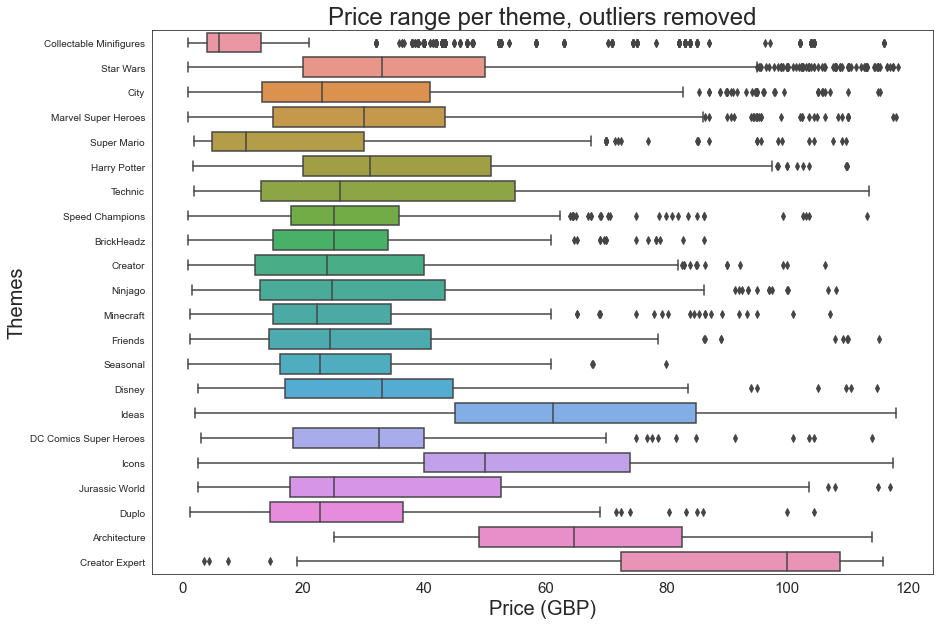

In [661]:
fig, ax = plt.subplots(figsize = (14,10))
order = df['Theme'].value_counts().index
ax = sns.boxplot(data=df, x='sold_price', y='Theme', order=order)
plt.xticks(size=15)
plt.ylabel('Themes', size = 20)
plt.xlabel('Price (GBP)', size = 20)

# ax2 = ax.twinx()
# df_mean = df.groupby(['Theme']).mean().loc[order]
# x = df_mean['RRP (GBP)']
# y = df_mean.index
# plt.plot(x, y)
# ax2 = sns.pointplot(data=df, x='RRP (GBP)', y='Theme', order=order, color='red') # Mean retail price

plt.title('Price range per theme, outliers removed', size = 24)
plt.show()

The results look better. However in some themes such 'Collectable Minifigures' the data is very skwed and the outliers is far away from the mean. So we explore the RRP and mean sale

In [662]:
df.groupby('Theme').mean()

,sold_price,Number,Minifigs,Pieces,RRP (GBP)
Theme,,,,,
Architecture,65.323974,21039.788079,NaN,771.536424,52.208543
BrickHeadz,27.166399,42878.657738,NaN,217.687500,14.878393
City,31.172866,59160.940299,3.523957,314.280597,37.085522
Collectable Minifigures,17.519536,69313.691834,1.445295,10.261787,3.251953
Creator,29.945671,32576.338415,2.401408,385.966463,29.058598
Creator Expert,86.074902,12918.000000,4.041667,1302.549020,93.421373
DC Comics Super Heroes,33.548156,72448.871508,3.006329,410.011173,38.948101
Disney,33.734211,44168.236842,2.546448,360.005263,38.811053
Duplo,28.719675,10774.779221,2.200000,43.376623,30.931558


Results look much better.
Clearly we can see each themes has its own price range.

## Total solds set size wise

### Cartogrise set size
* Small < 500 pcs
* Medium = 500-1000 pcs
* Large > 1000 pcs


In [663]:
df['Pieces'].max()

7541.0

In [664]:
df['Pieces'] = df['Pieces'].fillna(0).astype('int64')
df.loc[df['Pieces'] <= 500, 'Size'] = 'Small Set'
df.loc[(df['Pieces'] > 500) & (df['Pieces'] <= 1000) ,'Size'] = 'Medium Set'
df.loc[df['Pieces'] > 1000, 'Size'] = 'Large Set'

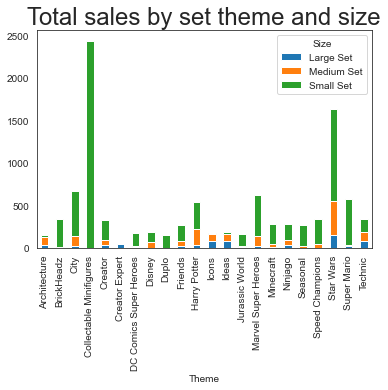

In [670]:
# fig, ax = plt.subplots(figsize=(14,6))
colors = sns.color_palette('pastel')
# ax = df['Size'].value_counts().plot.pie(autopct='%.1f%%', colors=colors, textprops={'fontsize': 14})
ax = df.groupby(['Theme','Size']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Total sales by set theme and size', size = 24)
# plt.ylabel('')
plt.show()

Most of the sets sold on Ebay are small sets. This might be due to small sets are cheaper compared to medium and large sets. So, in order to conduct further analysis, it might be useful to normalise the price.

## The median difference betwene the sale price and the retail price

In [ ]:
df['profit'] = df['sold_price'] - df['RRP (GBP)']
df.head()

In [ ]:
df.groupby('Size')['profit'].median()

Top 20 sets sold on Ebay by frequency

In [ ]:
top_sets = df['Number'].value_counts().to_frame().reset_index().head(20)
top_sets.columns = ['Number', 'frequency']
top_sets

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
order_list = top_sets.Number.to_list()
ax = sns.barplot(x = 'Number', y = 'frequency', data = top_sets, order=order_list)
plt.title('Top 10 sets by number of sold on Ebay', size = 15)
plt.xlabel('Set Numbers')
plt.ylabel('Number of sold')
plt.show()

Take a deeper look at the top 5 sets specifically.

In [ ]:
# top_sets2 = df_ebay_cleaned[df_ebay_cleaned['numbers'].isin(top_sets['set_numbers'])]
# cols = {'sold_price':'mean', 'sold_price':'std'}
# df_deep = df_ebay_cleaned[df_ebay_cleaned['numbers'].isin(top_sets['set_numbers'])].groupby('numbers', as_index=True).agg({'sold_price': ['mean','std', 'count']})
df_deep = df[df['Number'].isin(top_sets['Number'].head(5))]
df_deep['sold_price'] = df_deep['sold_price'].astype(float)
df_deep


Check Theme


In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
sns.set_style("white")
ax = sns.boxplot(data=df_deep, x='Number', y='sold_price', order=order_list[:5])
plt.ylabel('Sold Price')
ax2 = ax.twinx()
ax2 = sns.pointplot(data=df_deep, x='Number', y='RRP (GBP)', order=order_list[:5])
plt.ylabel('Retail Price')
plt.xlabel('Set Number')


As we can see, the prices for each set have some outliers. So a cleaning up needed to be done. 

Applying the interquartile filter to remove outliers:

In [ ]:
# IQR : Inter Quarltile Range
Q1 = df_deep['sold_price'].quantile(0.25)
Q3 = df_deep['sold_price'].quantile(0.75)
IQR = Q3 - Q1

df_deep = df_deep[~((df_deep['sold_price'] < (Q1 - 1.5 * IQR)) |(df_deep['sold_price'] > (Q3 + 1.5 * IQR)))]
fig, ax = plt.subplots(figsize = (14,6))
sns.set_style("white")
ax = sns.boxplot(data=df_deep, x='Number', y='sold_price', order=order_list[:5])
plt.xlabel('Set Number')
plt.ylabel('Sold Price')
ax2 = ax.twinx()
ax2 = sns.pointplot(data=df_deep, x='Number', y='RRP (GBP)', order=order_list[:5])
plt.ylabel('Retail Price')

The resulting is much cleaner. However, we noticed set 71033, 71034, 71410 has very broad price range while its data is very skewed

* sns.histplot for price per top sale sets
* Todo: sold_price vs minifigures, years: sns.barplot (stripplot) t
* Todo: correlation between all metrics
* Todo: average price per piece for different theme
* Todo: plot price vs theme using seaborn.regplot
* Todo: looking at correlation: df.corr(method = 'pearson'): sold_price, theme, pieces, minifigures, years, size. Plot sns.heatmap

# By Theme
# By Size
# By Years
# Search resale house price, resale sneakers
https://www.youtube.com/watch?v=V6V2qzJ4JFs
https://sameen73.github.io/stock_x_analysis.html